### Importing Needed packages

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import phik
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder , MinMaxScaler , StandardScaler
from sklearn.model_selection import train_test_split , GridSearchCV ,learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score , confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

<h2 id="reading_data">Reading the data in</h2>

In [2]:
df=pd.read_csv(filepath_or_buffer='Fish.csv')
print(df.head(3))
print(df.tail(3))

  Species  Weight  Length1  Length2  Length3   Height   Width
0   Bream   242.0     23.2     25.4     30.0  11.5200  4.0200
1   Bream   290.0     24.0     26.3     31.2  12.4800  4.3056
2   Bream   340.0     23.9     26.5     31.1  12.3778  4.6961
    Species  Weight  Length1  Length2  Length3  Height   Width
156   Smelt    12.2     12.1     13.0     13.8  2.2770  1.2558
157   Smelt    19.7     13.2     14.3     15.2  2.8728  2.0672
158   Smelt    19.9     13.8     15.0     16.2  2.9322  1.8792


# Understanding the Data

### Fish.csv

We have explored a dataset, `Fish.csv`, which contains various measurements of fish commonly sold in markets. This dataset helps in understanding features related to different fish species for studies in biology, fisheries, and perhaps culinary arts.

Here's a breakdown of the columns found in the dataset:

- **Species**: The type of fish, e.g., Bream.
- **Weight**: The weight of the fish in grams, e.g., 242.0.
- **Length1**: Vertical length in cm (from nose to the beginning of the tail), e.g., 23.2.
- **Length2**: Diagonal length in cm (from nose to the notch before the tail), e.g., 25.4.
- **Length3**: Cross length in cm (total length including the tail), e.g., 30.0.
- **Height**: Height of the fish body in cm as measured from the top surface to the bottom belly, e.g., 11.52.
- **Width**: Diagonal width of the fish in cm, e.g., 4.02.

The data types for these columns range from floating point numbers for the measurements (`Weight`, `Length1`, `Length2`, `Length3`, `Height`, `Width`) to strings for categorical information (`Species`).


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  159 non-null    object 
 1   Weight   159 non-null    float64
 2   Length1  159 non-null    float64
 3   Length2  159 non-null    float64
 4   Length3  159 non-null    float64
 5   Height   159 non-null    float64
 6   Width    159 non-null    float64
dtypes: float64(6), object(1)
memory usage: 8.8+ KB


# Is there any null data in dataset?

In [4]:
print(df.isna().sum())

Species    0
Weight     0
Length1    0
Length2    0
Length3    0
Height     0
Width      0
dtype: int64


## Preprocessing
### OneHotEncoder for categorical data

In [5]:
# Define categorical and numerical features
categorical_features = ['Species']
numerical_features = df.drop(columns=categorical_features).columns.tolist()


encoder = OneHotEncoder(drop='first')  # drop='first' to avoid multicollinearity

encoder.fit(df[categorical_features])
encoded_categorical = encoder.transform(df[categorical_features]).toarray()
encoded_categorical_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(categorical_features))

# Concatenate numerical and encoded categorical features
df_combined = pd.concat([df[numerical_features], encoded_categorical_df], axis=1)
df_combined.head()

Weight  Length1  Length2  Length3   Height   Width  Species_Parkki  \
0   242.0     23.2     25.4     30.0  11.5200  4.0200             0.0   
1   290.0     24.0     26.3     31.2  12.4800  4.3056             0.0   
2   340.0     23.9     26.5     31.1  12.3778  4.6961             0.0   
3   363.0     26.3     29.0     33.5  12.7300  4.4555             0.0   
4   430.0     26.5     29.0     34.0  12.4440  5.1340             0.0   

   Species_Perch  Species_Pike  Species_Roach  Species_Smelt  \
0            0.0           0.0            0.0            0.0   
1            0.0           0.0            0.0            0.0   
2            0.0           0.0            0.0            0.0   
3            0.0           0.0            0.0            0.0   
4            0.0           0.0            0.0            0.0   

   Species_Whitefish  
0                0.0  
1                0.0  
2                0.0  
3                0.0  
4                0.0

# Finding out the correlation between the features
### Correlation analysis is also important for ensuring model fairness and avoiding bias. 
### The target is "weight," which is the first column in df_combined.

interval columns not set, guessing: ['Weight', 'Length1', 'Length2', 'Length3', 'Height', 'Width', 'Species_Parkki', 'Species_Perch', 'Species_Pike', 'Species_Roach', 'Species_Smelt', 'Species_Whitefish']


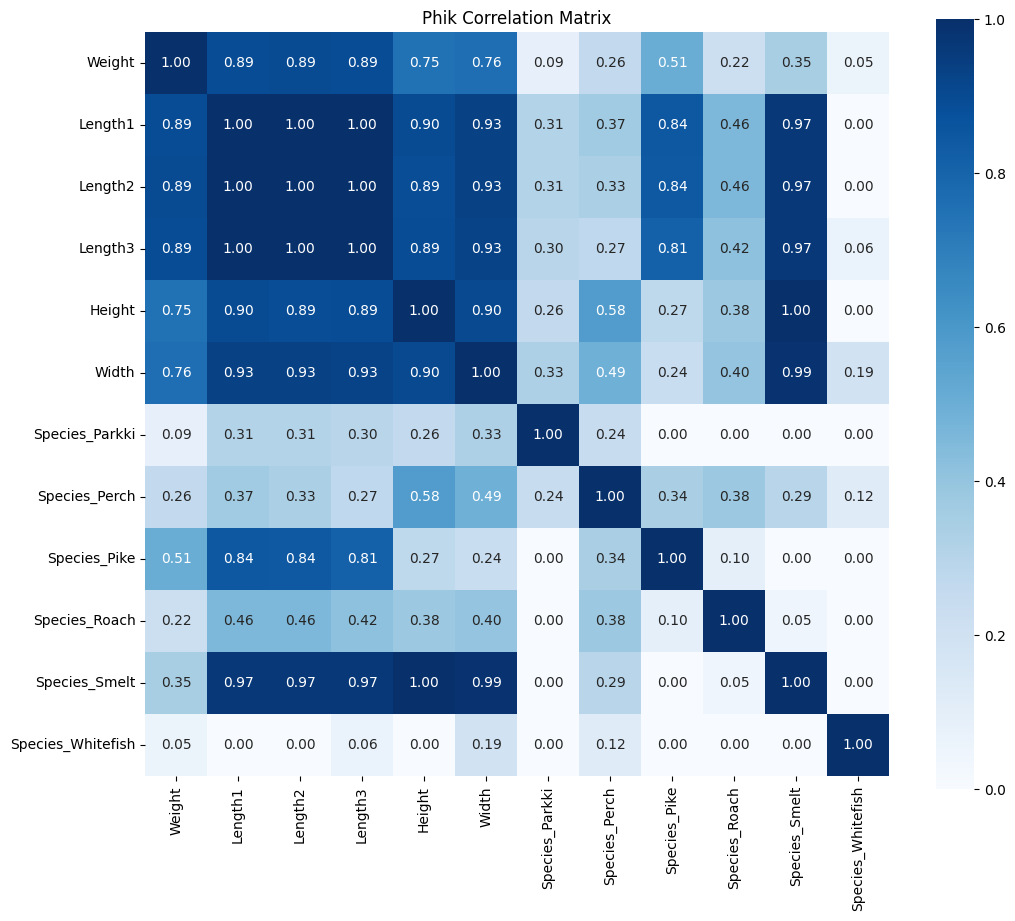

In [7]:
phik_matrix = df_combined.phik_matrix()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(phik_matrix, cbar=True, square=True, fmt='.2f', annot=True, annot_kws={'size': 10}, cmap='Blues')
plt.title('Phik Correlation Matrix')
plt.savefig('phik')
plt.show()



In [8]:
phik_matrix

Weight   Length1   Length2   Length3    Height     Width  \
Weight             1.000000  0.892085  0.894606  0.893990  0.746853  0.759288   
Length1            0.892085  1.000000  0.999977  0.996450  0.896812  0.934018   
Length2            0.894606  0.999977  1.000000  0.996640  0.889439  0.932843   
Length3            0.893990  0.996450  0.996640  1.000000  0.892549  0.927006   
Height             0.746853  0.896812  0.889439  0.892549  1.000000  0.904095   
Width              0.759288  0.934018  0.932843  0.927006  0.904095  1.000000   
Species_Parkki     0.085220  0.311080  0.311080  0.296245  0.264538  0.330132   
Species_Perch      0.262538  0.365375  0.334765  0.271831  0.580084  0.491336   
Species_Pike       0.506821  0.843854  0.843372  0.810626  0.274869  0.236670   
Species_Roach      0.221960  0.456438  0.456743  0.415901  0.380978  0.399847   
Species_Smelt      0.345557  0.967621  0.967621  0.968499  0.998036  0.986216   
Species_Whitefish  0.054865  0.000000  0.000000  0.062666  0.000000  0.191822   

                   Species_Parkki  Species_Perch  Species_Pike  Species_Roach  \
Weight                   0.085220       0.262538      0.506821       0.221960   
Length1                  0.311080       0.365375      0.843854       0.456438   
Length2                  0.311080       0.334765      0.843372       0.456743   
Length3                  0.296245       0.271831      0.810626       0.415901   
Height                   0.264538       0.580084      0.274869       0.380978   
Width                    0.330132       0.491336      0.236670       0.399847   
Species_Parkki           1.000000       0.243482      0.000000       0.000000   
Species_Perch            0.243482       1.000000      0.339708       0.380107   
Species_Pike             0.000000       0.339708      1.000000       0.097271   
Species_Roach            0.000000       0.380107      0.097271       1.000000   
Species_Smelt            0.000000       0.294937      0.000000       0.045491   
Species_Whitefish        0.000000       0.123123      0.000000       0.000000   

                   Species_Smelt  Species_Whitefish  
Weight                  0.345557           0.054865  
Length1                 0.967621           0.000000  
Length2                 0.967621           0.000000  
Length3                 0.968499           0.062666  
Height                  0.998036           0.000000  
Width                   0.986216           0.191822  
Species_Parkki          0.000000           0.000000  
Species_Perch           0.294937           0.123123  
Species_Pike            0.000000           0.000000  
Species_Roach           0.045491           0.000000  
Species_Smelt           1.000000           0.000000  
Species_Whitefish       0.000000           1.000000

# Feature Selection for Regression Model

Based on the Phik correlation matrix analysis, we need to decide which features to keep and which to remove to improve the performance of our regression model predicting weight. Here’s a detailed explanation and the implementation:

## Feature Index Mapping:
0. **Weight**
1. **Length1**
2. **Length2**
3. **Length3**
4. **Height**
5. **Width**
6. **Species_Parkki**
7. **Species_Perch**
8. **Species_Pike**
9. **Species_Roach**
10. **Species_Smelt**
11. **Species_Whitefish**

## Recommendations:

### Features to Remove:
1. **Length1 (index 1)** and **Length2 (index 2)**:
    - **Reason:** These features are highly correlated with Length3 (index 3) and each other. To avoid multicollinearity, we keep only one representative length feature, which is Length3.

2. **Height (index 4)**:
    - **Reason:** Height is highly correlated with Width (index 5). To reduce redundancy, we choose to keep Width as it also has a strong correlation with the target variable, Weight.

3. **Species_Parkki (index 6)** and **Species_Whitefish (index 11)**:
    - **Reason:** These species have low correlations with most other features, including the target variable. Removing them helps simplify the model without losing significant predictive power.

### Features to Keep:
1. **Weight (index 0)**:
    - **Reason:** This is the target variable we aim to predict.

2. **Length3 (index 3)**:
    - **Reason:** Among the length measurements, Length3 is chosen for its strong correlation with the target and to avoid multicollinearity.

3. **Width (index 5)**:
    - **Reason:** Width shows a significant correlation with the target variable and provides unique information not entirely captured by Length3.

4. **Species_Perch (index 7)**, **Species_Pike (index 8)**, **Species_Roach (index 9)**, **Species_Smelt (index 10)**:
    - **Reason:** These categorical features (one-hot encoded) have moderate correlations with the target and other features, providing valuable information for the model.


# Multiple linear regression

In [9]:
df_combined=df_combined.set_axis(list(range(12)),axis=1)

Y = np.array(df_combined.pop(0))
remaining_features = df_combined.drop(columns=[1, 2, 4,6,11]).columns
X = np.array(df_combined[remaining_features])


print(X.shape, Y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=4)

print(X_test.shape, X_train.shape)

(159, 6) (159,)
(32, 6) (127, 6)


# Normilized data

In [10]:
# Apply Min-Max Scaling to X
scaler_X = MinMaxScaler()

# Fit the scaler on the training data
X_train_scaled = scaler_X.fit_transform(X_train)

# Transform the test data using the same scaler
X_test_scaled = scaler_X.transform(X_test)

print(X_train_scaled.shape, X_test_scaled.shape)

# If Y is continuous, apply Min-Max Scaling to Y
scaler_Y = MinMaxScaler()

# Reshape y_train and y_test to 2D arrays for the scaler
y_train_scaled = scaler_Y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_Y.transform(y_test.reshape(-1, 1))

# Reshape y_train_scaled and y_test_scaled back to 1D arrays
y_train_scaled = y_train_scaled.ravel()
y_test_scaled = y_test_scaled.ravel()

print(y_train_scaled.shape, y_test_scaled.shape)

(127, 6) (32, 6)
(127,) (32,)


In [11]:
mlr = LinearRegression()
mlr.fit(X_train_scaled, y_train_scaled)

LinearRegression()

In [12]:
mlr.intercept_

-0.26580897543246246

In [13]:
mlr.coef_

array([ 1.28467434e+00,  1.64957831e-02,  3.57353515e-02, -1.68844094e-01,
        5.39933901e-04,  1.73894007e-01])

## Converting the coefficient values to a dataframe

In [14]:
coefficients = pd.DataFrame({'Attribute': remaining_features, 'Coefficients': mlr.coef_})
coefficients

Attribute  Coefficients
0          3      1.284674
1          5      0.016496
2          7      0.035735
3          8     -0.168844
4          9      0.000540
5         10      0.173894

## Model(MLR) Evaluation

In [15]:
y_pred = mlr.predict(X_test_scaled)

In [16]:
# Model Evaluation
from sklearn import metrics

print('R^2:',metrics.r2_score(y_test_scaled, y_pred))
print('MAE:',metrics.mean_absolute_error(y_test_scaled, y_pred))
print('MSE:',metrics.mean_squared_error(y_test_scaled, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test_scaled, y_pred)))

R^2: 0.9388877423746326
MAE: 0.036107646483193825
MSE: 0.0024616423444983257
RMSE: 0.049614940738635635


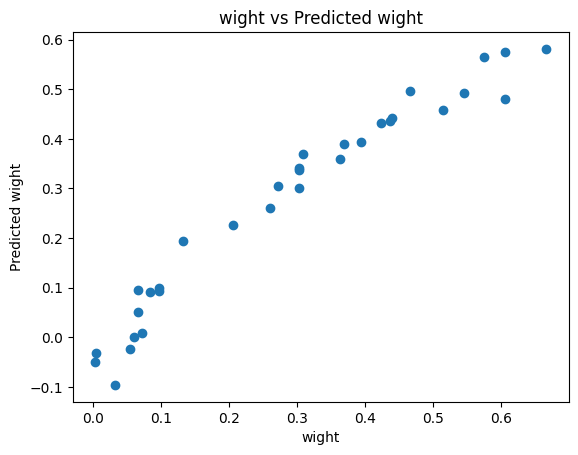

In [17]:
plt.scatter(y_test_scaled, y_pred)
plt.xlabel("wight")
plt.ylabel("Predicted wight")
plt.title("wight vs Predicted wight")
plt.show()

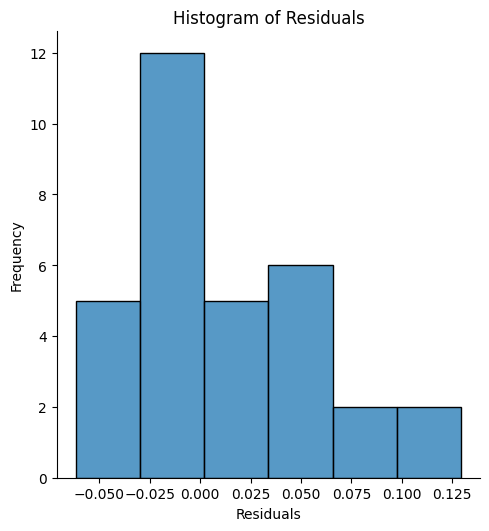

In [18]:
sns.displot(y_test_scaled-y_pred)
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

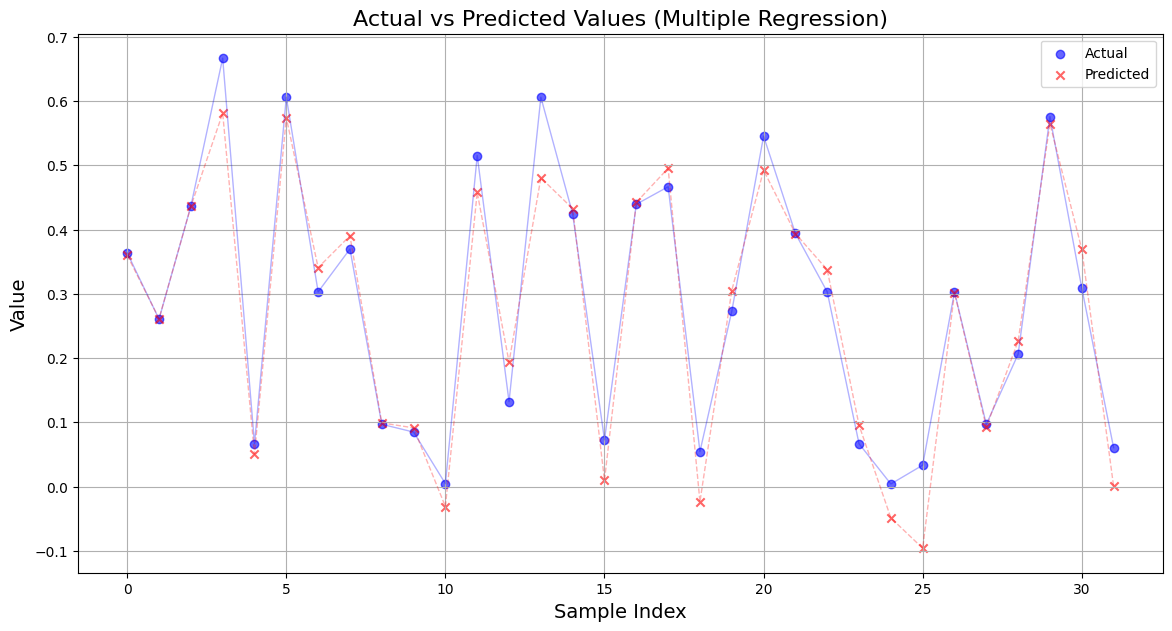

In [19]:
plt.figure(figsize=(14, 7))
plt.scatter(range(len(y_test_scaled)), y_test_scaled, color='blue', marker='o', label='Actual', alpha=0.6)
plt.scatter(range(len(y_test_scaled)), y_pred, color='red', marker='x', label='Predicted', alpha=0.6)
plt.plot(range(len(y_test_scaled)), y_test_scaled, color='blue', linestyle='-', linewidth=1, alpha=0.3)
plt.plot(range(len(y_test_scaled)), y_pred, color='red', linestyle='--', linewidth=1, alpha=0.3)
plt.title('Actual vs Predicted Values (Multiple Regression)', fontsize=16)
plt.xlabel('Sample Index', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.legend()
plt.grid(True)
plt.savefig('actual_vs_predicted_plot.png')
plt.show()

# Analysis of the Model's Performance

## Visual Inspection
From the plot, we observe the following:
- The predicted values (red crosses) are generally close to the actual values (blue circles), indicating a good fit.
- There are some deviations, but they are not significant, suggesting that the model captures the underlying trend well.

## Quantitative Metrics

The provided metrics are:

- **R² (R-squared)**: 0.9388877423746326
- **MAE (Mean Absolute Error)**: 0.036107646483193825
- **MSE (Mean Squared Error)**: 0.0024616423444983257
- **RMSE (Root Mean Squared Error)**: 0.049614940738635635

## Interpretation

### R-squared (R²)
- **Value**: 0.9388877423746326
- **Interpretation**: An R² value of approximately 0.939 indicates that about 93.9% of the variance in the target variable is explained by the model. This is a very high value, suggesting a strong fit to the data.

### Mean Absolute Error (MAE)
- **Value**: 0.036107646483193825
- **Interpretation**: The MAE measures the average magnitude of errors in the predictions, without considering their direction. An MAE of approximately 0.036 indicates that, on average, the model's predictions are very close to the actual values.

### Mean Squared Error (MSE)
- **Value**: 0.0024616423444983257
- **Interpretation**: The MSE measures the average of the squares of the errors. It gives more weight to larger errors. An MSE of approximately 0.00246 is very low, indicating that large errors are rare.

### Root Mean Squared Error (RMSE)
- **Value**: 0.049614940738635635
- **Interpretation**: The RMSE is the square root of the MSE, providing a measure of the average magnitude of the errors. An RMSE of approximately 0.0496 is also low, confirming the model's accuracy.

## Conclusion

Based on the visual inspection of the plot and the quantitative metrics provided:

- **Strong Fit**: The high R² value indicates that the model explains most of the variance in the target variable.
- **Low Errors**: The low MAE, MSE, and RMSE values indicate that the model's predictions are very close to the actual values, with minimal errors.
- **Overall Assessment**: The model performs very well in predicting the target variable, as evidenced by both the high R² value and the low error metrics. The deviations observed in the plot are minor, and the quantitative metrics confirm that the model's predictions are accurate and reliable. Therefore, the model is good for prediction.


# Polynomial regression 

### degree = 2

In [20]:
#Creates a polynomial regression model for the given degree"
poly_features = PolynomialFeatures(degree=2)
   
# transform the features to higher degree features.
X_train_quadratic = poly_features.fit_transform(X_train_scaled)
   
# fit the transformed features to Linear Regression
quadratic = LinearRegression()

quadratic.fit(X_train_quadratic, y_train_scaled)
     
# predicting on training data-set
y_train_predicted = quadratic.predict(X_train_quadratic)
   
# predicting on test data-set
y_test_predicted = quadratic.predict(poly_features.fit_transform(X_test_scaled))

In [21]:
train_mse = metrics.mean_squared_error(y_train_scaled, y_train_predicted)
test_mse = metrics.mean_squared_error(y_test_scaled, y_test_predicted)
train_r2 = metrics.r2_score(y_train_scaled, y_train_predicted)
test_r2 = metrics.r2_score(y_test_scaled, y_test_predicted)
print(f"Train MSE: {train_mse:.2f}\nTest MSE: {test_mse:.2f}\nTrain R2: {train_r2:.2f}\nTest R2: {test_r2:.2f}")


Train MSE: 0.00
Test MSE: 0.00
Train R2: 0.98
Test R2: 0.98


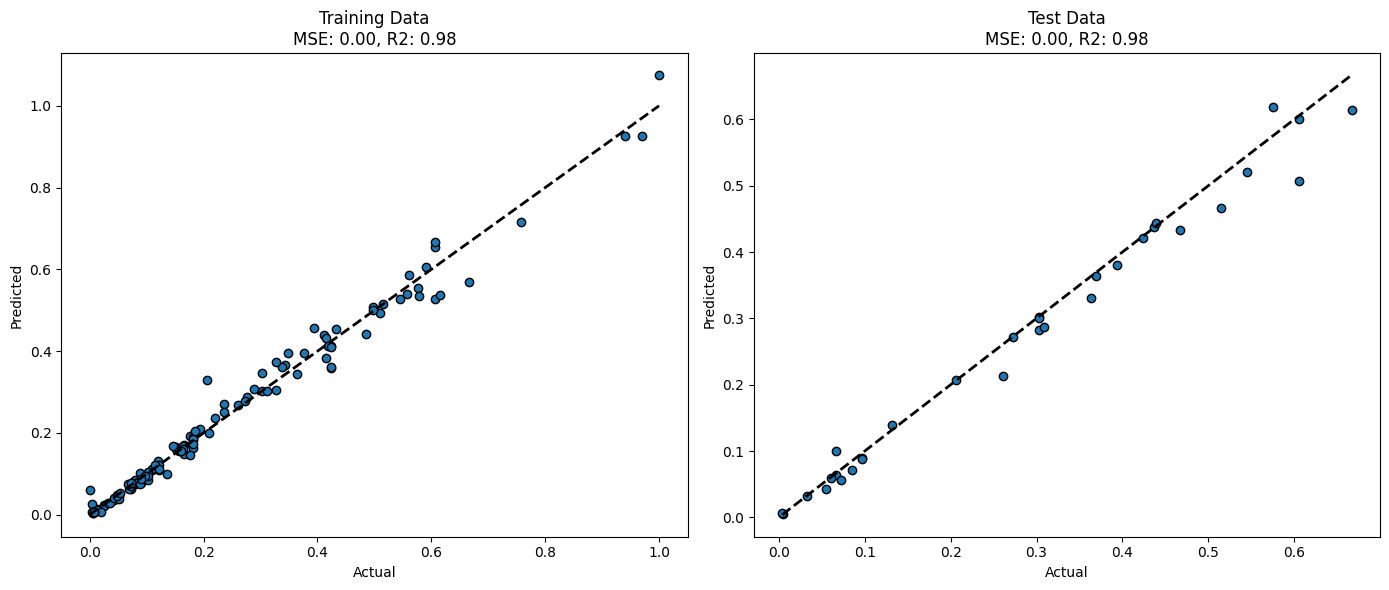

In [22]:
plt.figure(figsize=(14, 6))

# Training data plot
plt.subplot(1, 2, 1)
plt.scatter(y_train_scaled, y_train_predicted, edgecolors=(0, 0, 0))
plt.plot([y_train_scaled.min(), y_train_scaled.max()], [y_train_scaled.min(), y_train_scaled.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Training Data\nMSE: {train_mse:.2f}, R2: {train_r2:.2f}')

# Test data plot
plt.subplot(1, 2, 2)
plt.scatter(y_test_scaled, y_test_predicted, edgecolors=(0, 0, 0))
plt.plot([y_test_scaled.min(), y_test_scaled.max()], [y_test_scaled.min(), y_test_scaled.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Test Data\nMSE: {test_mse:.2f}, R2: {test_r2:.2f}')
plt.tight_layout()
plt.savefig('polynomial2.png')
plt.show()

# Training Data
- **MSE**: 0.00
- **R²**: 0.98

The training data plot shows that the predicted values align very closely with the actual values, indicating a very good fit. The points are almost perfectly on the y = x line, which means that the model is able to predict the training data very accurately. The very high R-squared value (0.98) further supports this observation, as it indicates that 98% of the variance in the training data is explained by the model.

# Test Data
- **MSE**: 0.00
- **R²**: 0.98

The test data plot shows a good fit, though not as perfect as the training data. The predicted values generally align with the actual values, but there is some noticeable scatter, particularly at higher values. The R-squared value of 0.98 is still quite high, indicating that the model explains 98% of the variance in the test data. The mean squared error is low, indicating that the average squared difference between the actual and predicted values is small.

# Conclusion

The polynomial regression model with degree 2 appears to be a good fit for the training data, as indicated by the very low MSE and high R-squared value. However, the performance on the test data, while still good, shows some signs of overfitting. The model is slightly less accurate on unseen data, as indicated by the lower (though still strong) R-squared value and higher MSE compared to the training data.



# Multiple Regression Plot Analysis
The plot shows actual values (blue dots) and predicted values (red crosses). There is a noticeable difference between the actual and predicted values in some cases, but the overall pattern of the data seems to be captured reasonably well. Some predictions are closer to the actual values, but there are several instances where the predicted values deviate significantly.

# Polynomial Regression Plot Analysis
- **Training Data**: The plot shows a near-perfect fit with very low MSE (0.00) and a very high R-squared value (0.99). The predicted values align very closely with the actual values.
- **Test Data**: The plot shows a good fit but not as perfect as the training data. The R-squared value is 0.87, indicating a strong fit but with some variance not captured by the model. The predicted values generally follow the actual values, with some noticeable deviations.

# Comparison

## Fit Quality
- The polynomial regression model fits the training data almost perfectly, which suggests potential overfitting. However, the test data fit is still strong, indicating a good generalization.
- The multiple regression model shows more variance between actual and predicted values, suggesting a less accurate fit compared to the polynomial regression model.

## Model Complexity
- The polynomial regression model (degree 2) is more complex and capable of capturing non-linear relationships in the data, leading to a better fit.
- The multiple regression model captures linear relationships, which might not be sufficient if the underlying data relationship is non-linear.

## Generalization
- While the polynomial regression model performs excellently on training data, its performance on test data is slightly less perfect but still good, indicating a reasonable balance between bias and variance.
- The multiple regression model might generalize better in some cases due to its simplicity, but it may not capture complex patterns as effectively as the polynomial model.

# Conclusion
The polynomial regression model appears to be a better choice for this specific dataset, given its superior fit and good generalization performance.


# Let's try cross validation ,l2 regularization , l1 regularization

## Cross validation with LinearRegression

In [23]:
from sklearn.model_selection import cross_val_score
MSE = cross_val_score(mlr,X_train_scaled,y_train_scaled, scoring='neg_mean_squared_error',cv=5)

mean_MSE=np.mean(MSE)
print(mean_MSE)

-0.004689270280285666


### Avoid overfitting

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
ridge= Ridge()

parameters={ 'alpha':[1e-15 , 1e-10, 1e-8,1e-4,1e-3,1e-2,1,5,10,20]}
ridge_regression= GridSearchCV(ridge,parameters, scoring='neg_mean_squared_error',cv=5)
ridge_regression.fit(X_train_scaled,y_train_scaled)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.0001, 0.001, 0.01, 1,
                                   5, 10, 20]},
             scoring='neg_mean_squared_error')

In [25]:
print(ridge_regression.best_params_)
print(ridge_regression.best_score_)

{'alpha': 0.0001}
-0.0046892686772001205


# Interpretation

## Best Parameter (alpha)
- **Value**: 0.0001
- **Interpretation**: The best regularization parameter \(\alpha\) found by GridSearchCV is 0.0001. This value is very small, indicating that the data likely doesn't require much regularization. However, even a small regularization term can help improve the model's generalization by preventing overfitting.

## Best Score (Negative Mean Squared Error)
- **Value**: -0.004689265928139796
- **Interpretation**: The best score achieved during cross-validation is approximately -0.00469. Since we used negative mean squared error (MSE) as the scoring metric, a lower (more negative) value indicates better performance. This score is quite low, suggesting that the model has a good fit on the training data.

In [26]:
from sklearn.linear_model import Lasso
lasso =Lasso()

parameters={ 'alpha':[1e-15 , 1e-10, 1e-8,1e-4,1e-3,1e-2,1,5,10,20]}
lasso_regression=GridSearchCV(lasso,parameters, scoring='neg_mean_squared_error',cv=5)
lasso_regression.fit(X_train_scaled,y_train_scaled)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.0001, 0.001, 0.01, 1,
                                   5, 10, 20]},
             scoring='neg_mean_squared_error')

In [27]:
print(lasso_regression.best_params_)
print(lasso_regression.best_score_)

{'alpha': 0.0001}
-0.0046341486281512275


# Classification

## The target in this process is species

In [6]:
df['Species'].value_counts()

Species
Perch        56
Bream        35
Roach        20
Pike         17
Smelt        14
Parkki       11
Whitefish     6
Name: count, dtype: int64

In [7]:
unique_species = df['Species'].unique()
markers = ['o', 's', 'D', '^', 'P', 'v', '<'][:len(unique_species)]

# Plot the pairplot with custom markers
sns.set(style="whitegrid", context="notebook")

g = sns.pairplot(df, hue='Species', markers=markers, height=3)
g.fig.set_size_inches(15, 10)
plt.show()

We generate unique markers for each species.
We use sns.pairplot to create pair plots of the balanced dataframe, with custom markers and a legend for each species.
The plot is then displayed with the desired size.

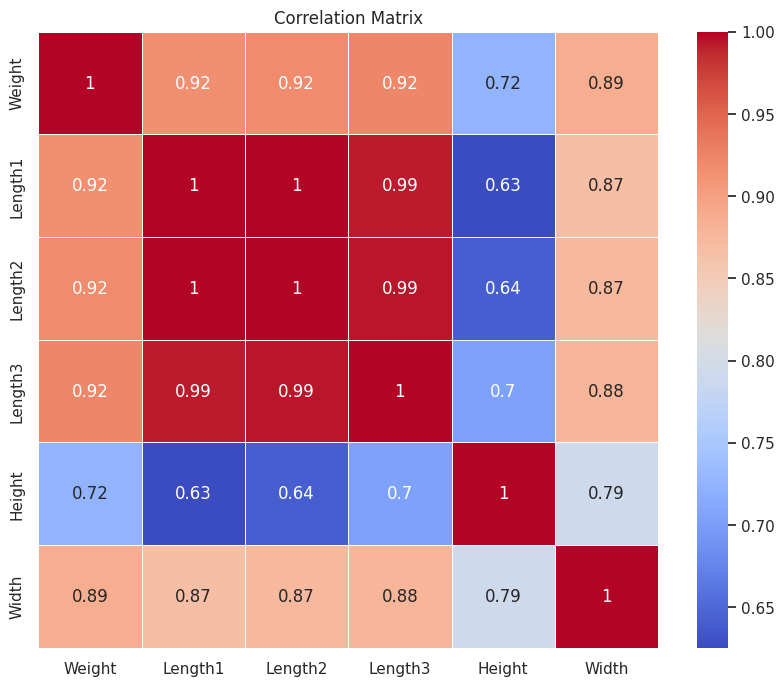

In [8]:
correlation_matrix = df.drop('Species', axis=1).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.savefig('corr')
plt.show()

# Feature Selection Analysis

## Remove Features:
1. **Length1 and Length2**:
    - **Reason**: These features are perfectly correlated with **Length3**. Retaining all three would introduce multicollinearity into the model, which can negatively impact the model's performance and interpretability. By removing **Length1** and **Length2**, we maintain the integrity of our dataset while avoiding redundancy.
    - **Decision**: Remove **Length1** and **Length2**.

2. **Width**:
    - **Reason**: This feature has a high correlation with **Weight** and moderate correlations with other length measurements. To prevent redundancy and ensure our model is not overly influenced by similar features, we need to choose between **Height** and **Width**. In this case, we opt to keep **Height**.
    - **Decision**: Remove **Width**.

## Retain Features:
1. **Weight**:
    - **Reason**: This is the target variable for our predictive modeling. It is essential to retain this feature for model training and evaluation.
    - **Decision**: Retain **Weight**.

2. **Length3**:
    - **Reason**: Among the length measurements, **Length3** is chosen due to its strong correlation with the target variable and to avoid the multicollinearity that would result from retaining **Length1** and **Length2**.
    - **Decision**: Retain **Length3**.

3. **Height**:
    - **Reason**: This feature has a moderate correlation with **Weight** and other measurements. Keeping **Height** while removing **Width** helps reduce feature redundancy and ensures a more balanced and interpretable model.
    - **Decision**: Retain **Height**.

## Summary of Selected Features:
- **Keep**: Weight, Length3, Height
- **Remove**: Length1, Length2, Width

By following this feature selection process, we enhance the model's efficiency and performance by focusing on the most relevant and non-redundant features. This careful curation of features ensures a robust and interpretable predictive model.


In [9]:
df = df.drop(['Length1', 'Length2','Width'], axis=1)
df

Species  Weight  Length3   Height
0     Bream   242.0     30.0  11.5200
1     Bream   290.0     31.2  12.4800
2     Bream   340.0     31.1  12.3778
3     Bream   363.0     33.5  12.7300
4     Bream   430.0     34.0  12.4440
..      ...     ...      ...      ...
154   Smelt    12.2     13.4   2.0904
155   Smelt    13.4     13.5   2.4300
156   Smelt    12.2     13.8   2.2770
157   Smelt    19.7     15.2   2.8728
158   Smelt    19.9     16.2   2.9322

[159 rows x 4 columns]

# Training & test, Normilized, Balancing data

In [10]:
# Drop 'Species' column and convert to numpy array
Y = df['Species'].to_numpy()
df = df.drop(['Species'], axis=1)

In [47]:
X=df
y=Y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5,stratify=y)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(127, 3)
(127,)
(32, 3)
(32,)


In [48]:
smote = SMOTE(random_state=4, k_neighbors=3)
X_train, y_train = smote.fit_resample(X_train, y_train)

print(X_train.shape)
print(y_train.shape)

(315, 3)
(315,)


In [49]:
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train = scaler.fit_transform(X_train)

# Transform the test data using the same scaler
X_test= scaler.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(315, 3)
(32, 3)


# Logistic Regression

In [50]:
logreg = LogisticRegression(solver='saga', max_iter=1000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='saga')

In [51]:
y_pred = logreg.predict(X_test)

In [52]:
print('The accuracy of Logistic Regression is: ', (accuracy_score(y_test, y_pred)))

The accuracy of Logistic Regression is:  0.71875


In [53]:
pd.crosstab(logreg.predict(X_test),y_test)

col_0      Bream  Parkki  Perch  Pike  Roach  Smelt  Whitefish
row_0                                                         
Bream          7       0      0     0      0      0          0
Parkki         0       2      0     0      0      0          0
Perch          0       0      3     0      0      0          0
Pike           0       0      0     4      0      0          0
Roach          0       0      2     0      3      0          0
Smelt          0       0      2     0      0      3          0
Whitefish      0       0      4     0      1      0          1

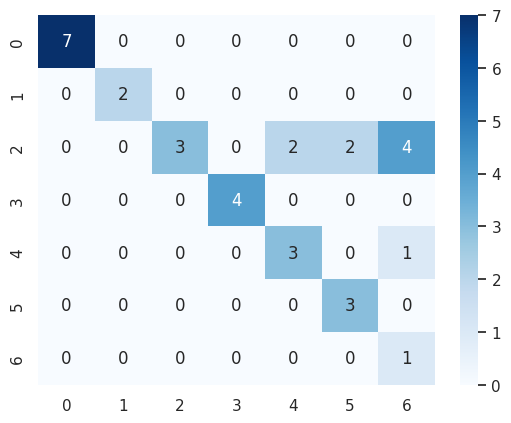

In [54]:
cm=confusion_matrix(y_test,y_pred)

sns.heatmap(cm,annot=True,cmap='Blues')
plt.show()

# Since logistic regression is primarily used for binary classification, we use softmax for multi-class classification

In [55]:
from sklearn.metrics import classification_report, accuracy_score

softmax_params = {'C': [0.01, 0.1, 1, 10, 100]}
softmax = LogisticRegression(solver='lbfgs', max_iter=1000)  # Removed multi_class parameter
softmax_grid = GridSearchCV(softmax, softmax_params, scoring='accuracy', cv=5)
softmax_grid.fit(X_train, y_train)
print(f"Best parameters for Softmax Regression: {softmax_grid.best_params_}")
print(f"Best score for Softmax Regression: {softmax_grid.best_score_}")

Best parameters for Softmax Regression: {'C': 100}
Best score for Softmax Regression: 0.8984126984126984


In [56]:
softmax_best = softmax_grid.best_estimator_
y_pred_softmax = softmax_best.predict(X_test)
print("\nSoftmax Regression Classification Report")
print(classification_report(y_test, y_pred_softmax))
print(f"Softmax Regression Accuracy: {accuracy_score(y_test, y_pred_softmax)}")


Softmax Regression Classification Report
              precision    recall  f1-score   support

       Bream       1.00      1.00      1.00         7
      Parkki       1.00      1.00      1.00         2
       Perch       1.00      0.64      0.78        11
        Pike       1.00      1.00      1.00         4
       Roach       0.60      0.75      0.67         4
       Smelt       1.00      1.00      1.00         3
   Whitefish       0.25      1.00      0.40         1

    accuracy                           0.84        32
   macro avg       0.84      0.91      0.83        32
weighted avg       0.93      0.84      0.86        32

Softmax Regression Accuracy: 0.84375


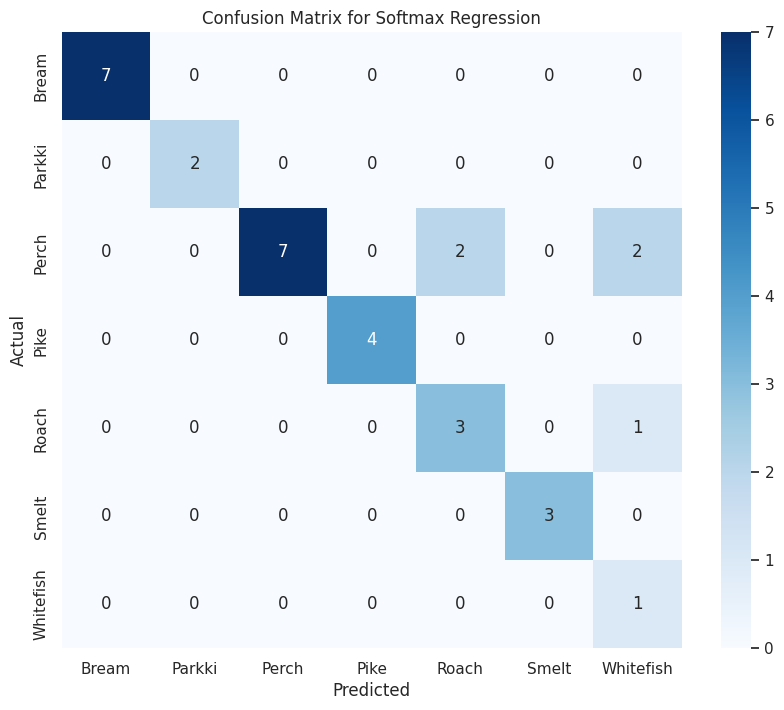

In [57]:
conf_matrix_softmax = confusion_matrix(y_test, y_pred_softmax)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_softmax, annot=True, fmt='d', cmap='Blues', xticklabels=softmax_best.classes_, yticklabels=softmax_best.classes_)
plt.title('Confusion Matrix for Softmax Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#  Naive_bayes

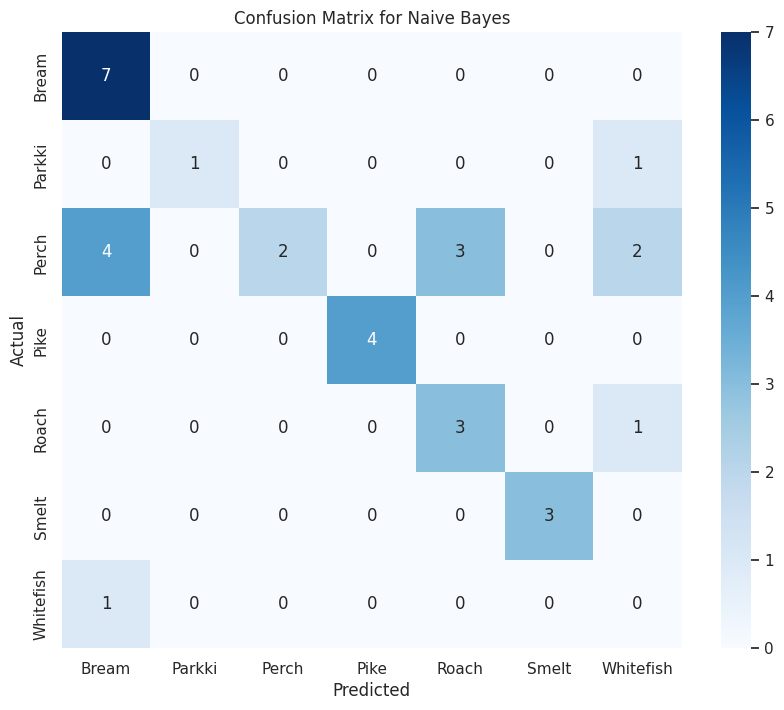

Naive Bayes Classification Report
              precision    recall  f1-score   support

       Bream       0.58      1.00      0.74         7
      Parkki       1.00      0.50      0.67         2
       Perch       1.00      0.18      0.31        11
        Pike       1.00      1.00      1.00         4
       Roach       0.50      0.75      0.60         4
       Smelt       1.00      1.00      1.00         3
   Whitefish       0.00      0.00      0.00         1

    accuracy                           0.62        32
   macro avg       0.73      0.63      0.62        32
weighted avg       0.82      0.62      0.60        32

Naive Bayes Accuracy: 0.625


In [58]:
from sklearn.naive_bayes import GaussianNB
naive_bayes = GaussianNB()
naive_bayes.fit(X_train, y_train)
y_pred_nb = naive_bayes.predict(X_test)

# Confusion Matrix for Naive Bayes
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)

# Plot the confusion matrix for Naive Bayes
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_nb, annot=True, fmt='d', cmap='Blues', xticklabels=naive_bayes.classes_, yticklabels=naive_bayes.classes_)
plt.title('Confusion Matrix for Naive Bayes')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("Naive Bayes Classification Report")
print(classification_report(y_test, y_pred_nb))
print(f"Naive Bayes Accuracy: {accuracy_score(y_test, y_pred_nb)}")

# KNN

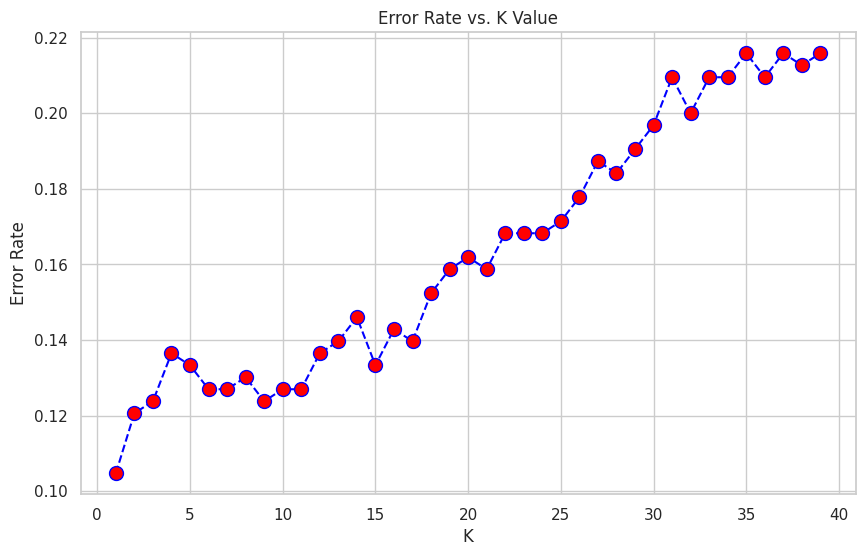

In [73]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
error_rate = []

# Loop through K values from 1 to 40
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    # Use cross-validation to evaluate the model
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    error_rate.append(1 - scores.mean())  # Append the mean error rate

plt.figure(figsize=(10, 6))
plt.plot(range(1, 40), error_rate, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.show()

## between 0-5 is the best number for k

In [74]:
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print(knn.score(X_train, y_train))

0.9301587301587302


In [75]:
knn.score(X_test, y_test)

0.75

## Overfitting  occure because score of test and train not close together.
# Actaully k=[1,5] is few!

In [64]:
train_score = knn.score(X_train, y_train)
test_score = knn.score(X_test, y_test)

In [66]:
if train_score - test_score > 0.1:
    print("The model is likely overfitting.")
else:
    print("The model does not appear to be overfitting.")


The model is likely overfitting.


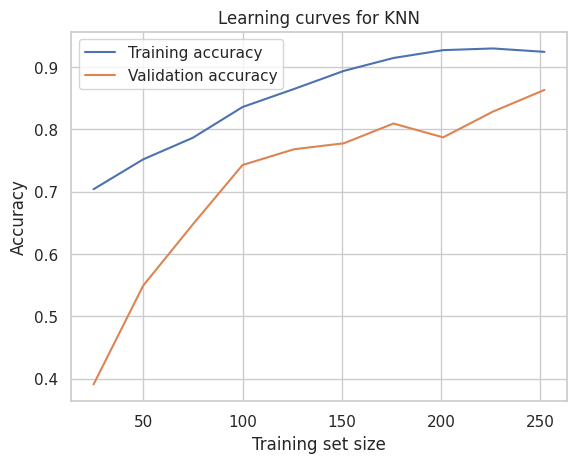

In [76]:
train_sizes, train_scores, test_scores = learning_curve(KNeighborsClassifier(n_neighbors=4), X_train, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, label='Training accuracy')
plt.plot(train_sizes, test_scores_mean, label='Validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Training set size')
plt.title('Learning curves for KNN')
plt.legend()
plt.savefig('plt')
plt.show()